In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np
import math
from matplotlib import pyplot as plt 
from datasets import load_dataset
import pandas as pd

/home/tony/FHE-BERT-Tiny/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#The same as https://huggingface.co/google/bert_uncased_L-2_H-128_A-2

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def precision(correct, approx):
    if type(approx) == list:
        approx = np.array(approx)
    absolute = sum(abs(correct - approx))/len(correct)
    relative = absolute / (sum(abs(correct))/len(correct))
    return 1 - relative

In [4]:
trained = torch.load('SST-2-BERT-tiny.bin', map_location=torch.device('cpu'))
trained.pop('bert.embeddings.position_ids', None) # Remove unexpected keys
model.load_state_dict(trained , strict=True)

model.eval()

/tmp/ipykernel_11832/3694534078.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained = torch.load('SST-2-BERT-tiny.bin', map_location=torch.device('cpu'))


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-1

In [5]:
def softmax_contribuisci(x, index = 1):
    if index == 1:
        input_exp_1.append(torch.max(x).item())
        input_exp_1.append(torch.min(x).item())
    else:
        input_exp_2.append(torch.max(x).item())
        input_exp_2.append(torch.min(x).item())
    
    for head in x.squeeze():
        for row in head:
            if index == 1:
                input_inv_1.append(torch.sum(torch.exp(row)).item())
            else:
                input_inv_2.append(torch.sum(torch.exp(row)).item())
                
    return torch.softmax(x, -1)

In [6]:
dataset = pd.read_parquet("SST-2-val.parquet")

In [7]:
input_exp_1 = []
input_inv_1 = []
input_gelu_1 = np.array([])
input_exp_2 = []
input_inv_2 = []
input_gelu_2 = np.array([])
input_tanh = np.array([])

fhe_correct = 0
fhe_wrong = 0

fhe_accuracy = 0
std_accuracy = 0

for ind in dataset.index:
    text = "[CLS] " + dataset['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and dataset['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and dataset['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and dataset['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and dataset['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

In [8]:
print("Standard model accuracy:    {}\nPrecomputed model accuracy: {}".format(std_accuracy / len(dataset.index), fhe_accuracy / len(dataset.index)))

Standard model accuracy:    0.8371559633027523
Precomputed model accuracy: 0.8153669724770642


1.8901038254064202
4842.979686693333


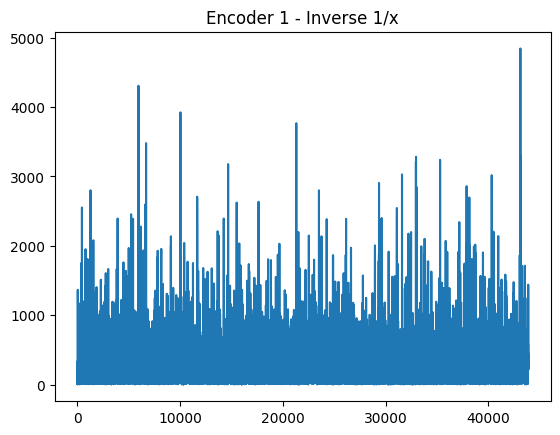

In [9]:
plt.title("Encoder 1 - Inverse 1/x")
plt.plot(input_inv_1)
print(min(input_inv_1))
print(max(input_inv_1))

-13.433753367714479
10.085527037811042


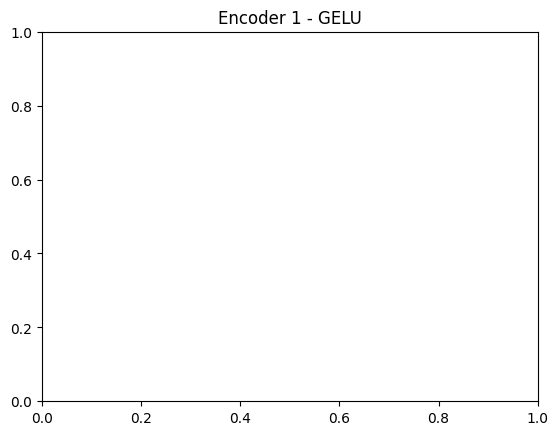

In [10]:
plt.title("Encoder 1 - GELU")
input_gelu_1 = np.array(input_gelu_1).reshape(-1)
#plt.plot(input_gelu_1)
print(min(input_gelu_1))
print(max(input_gelu_1))

2.305127670007339
1295320.8284727756


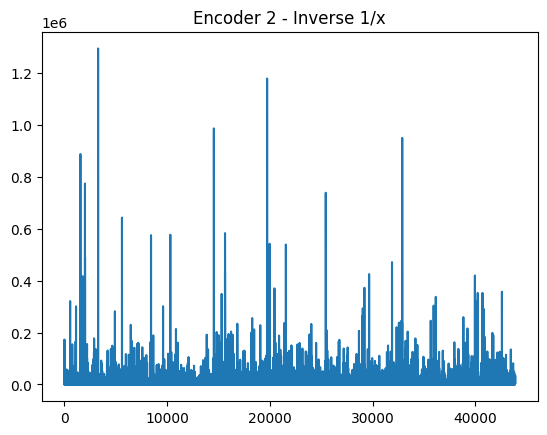

In [11]:
plt.title("Encoder 2 - Inverse 1/x")
plt.plot(input_inv_2)
print(min(input_inv_2))
print(max(input_inv_2))

-12.625016527033283
17.311076502570874


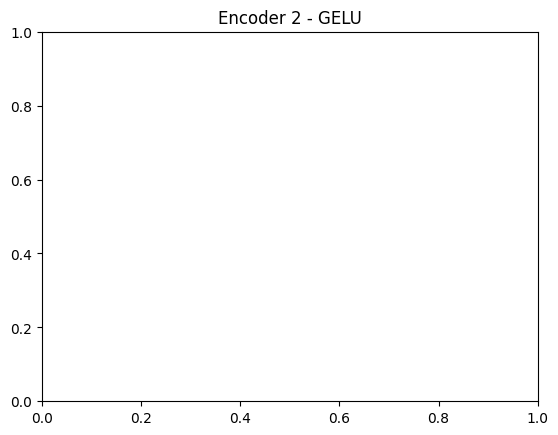

In [12]:
plt.title("Encoder 2 - GELU")
input_gelu_1 = np.array(input_gelu_2).reshape(-1)
print(min(input_gelu_2))
print(max(input_gelu_2))

-30.919249593086583
27.77145678725083


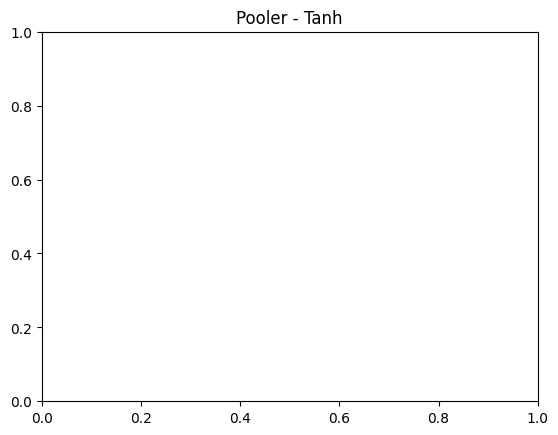

In [13]:
plt.title("Pooler - Tanh")
print(min(input_tanh))
print(max(input_tanh))

# 1/e

In [47]:
import numpy as np
from numpy.polynomial import Chebyshev
import matplotlib.pyplot as plt

In [75]:
def func_inv(x):
    return 1 / x

a, b = 2, 5000

def normalize(x):
    return (2 * x - (b + a)) / (b - a)

def denormalize(x_norm):
    return ((x_norm * (b - a)) + (b + a)) / 2

In [49]:
def compute_error(n):
    # Compute Chebyshev approximation of degree n
    x_cheb = np.polynomial.chebyshev.chebpts2(n + 1)
    x = denormalize(x_cheb)
    y = func_inv(x)
    coef = Chebyshev.fit(x_cheb, y, n).coef
    cheb_poly = Chebyshev(coef)
    
    # Compute maximum error over a dense set of points
    x_dense = np.linspace(a, b, 10000)
    x_norm = normalize(x_dense)
    y_true = func_inv(x_dense)
    y_approx = cheb_poly(x_norm)
    error = np.max(np.abs(y_true - y_approx))
    return error


In [89]:
epsilon = 4.2e-3  # Target approximation error # 0.004273725775988779
n = 1
while True:
    error = compute_error(n)
    if error < epsilon:
        break
    n += 1

print(f"Degree required for 1/x over [{a}, {b}] with error < {epsilon}: n = {n}")
print(f"Maximum error achieved: {error}")

Degree required for 1/x over [2, 5000] with error < 0.0042: n = 120
Maximum error achieved: 0.004094904335289307


In [101]:
def func_inv(x):
    return 1 / x

a, b = 3, 130000

def normalize(x):
    return (2 * x - (b + a)) / (b - a)

def denormalize(x_norm):
    return ((x_norm * (b - a)) + (b + a)) / 2

epsilon = 3e-2  # Target approximation error # 0.02946140865810594
n = 1
while True:
    error = compute_error(n)
    if error < epsilon:
        break
    n += 1

print(f"Degree required for 1/x over [{a}, {b}] with error < {epsilon}: n = {n}")
print(f"Maximum error achieved: {error}")

Degree required for 1/x over [3, 130000] with error < 0.03: n = 186
Maximum error achieved: 0.02983583028973557


In [18]:
## NOT MATCH!!

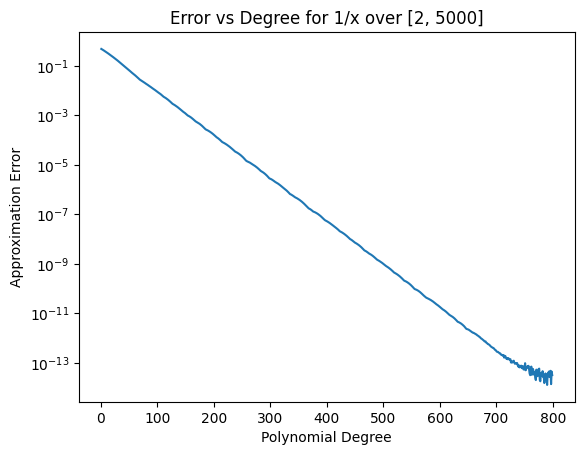

In [80]:
a, b = 2, 5000

degrees = []
errors = []
for n in range(1, 800):
    error = compute_error(n)
    degrees.append(n)
    errors.append(error)

plt.plot(degrees, errors)
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Approximation Error')
plt.title('Error vs Degree for 1/x over [{}, {}]'.format(a, b))
plt.show()


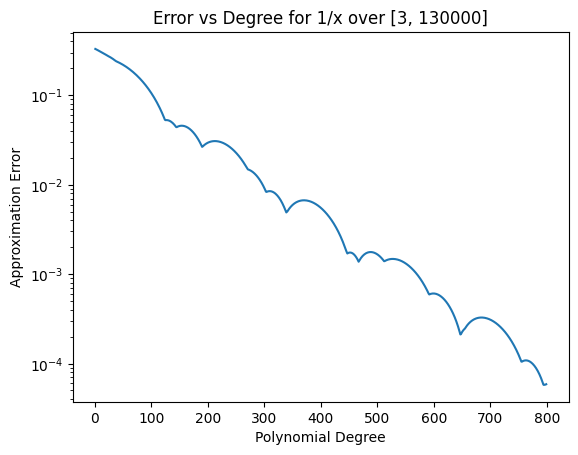

In [81]:
a, b = 3, 130000

degrees = []
errors = []
for n in range(1, 800):
    error = compute_error(n)
    degrees.append(n)
    errors.append(error)

plt.plot(degrees, errors)
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Approximation Error')
plt.title('Error vs Degree for 1/x over [{}, {}]'.format(a, b))
plt.show()


# GELU

In [52]:
from scipy.special import erf

def func_gelu(x):
    return x * 0.5 * (1 + erf(x / np.sqrt(2)))

a, b = -14, 11  # Adjust as per your data

def compute_error_gelu(n):
    # Normalize interval
    x_cheb = np.polynomial.chebyshev.chebpts2(n + 1)
    x = denormalize(x_cheb)
    y = func_gelu(x)
    coef = Chebyshev.fit(x_cheb, y, n).coef
    cheb_poly = Chebyshev(coef)
    
    # Compute error
    x_dense = np.linspace(a, b, 1000)
    x_norm = normalize(x_dense)
    y_true = func_gelu(x_dense)
    y_approx = cheb_poly(x_norm)
    error = np.max(np.abs(y_true - y_approx))
    return error


In [118]:
epsilon = 7e-14  # Target approximation error # 7.105427357601002e-14
n = 1
while True:
    error = compute_error_gelu(n)
    if error < epsilon:
        break
    n += 1

print(f"Degree required for gelu over [{a}, {b}] with error < {epsilon}: n = {n}")
print(f"Maximum error achieved: {error}")


Degree required for gelu over [-14, 11] with error < 7e-14: n = 100
Maximum error achieved: 6.217248937900877e-14


In [132]:
a, b = -18, 8  # Adjust as per your data

epsilon = 1.8e-6  # Target approximation error #1.8033960389185477e-06
n = 1
while True:
    error = compute_error_gelu(n)
    if error < epsilon:
        break
    n += 1

print(f"Degree required for gelu over [{a}, {b}] with error < {epsilon}: n = {n}")
print(f"Maximum error achieved: {error}")

Degree required for gelu over [-18, 8] with error < 1.8e-06: n = 58
Maximum error achieved: 1.601763268466172e-06


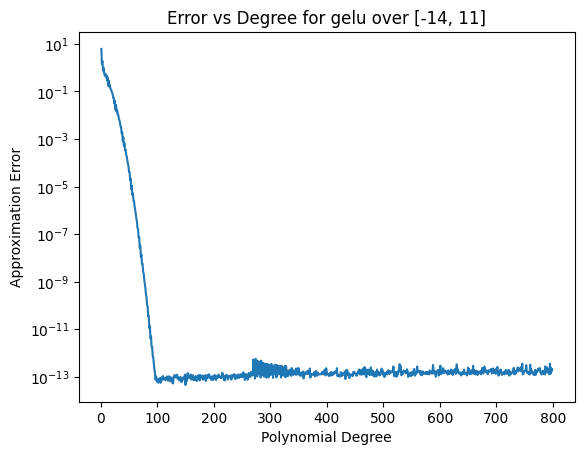

In [82]:
a, b = -14, 11

degrees = []
errors = []
for n in range(1, 800):
    error = compute_error_gelu(n)
    degrees.append(n)
    errors.append(error)

plt.plot(degrees, errors)
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Approximation Error')
plt.title('Error vs Degree for gelu over [{}, {}]'.format(a, b))
plt.show()

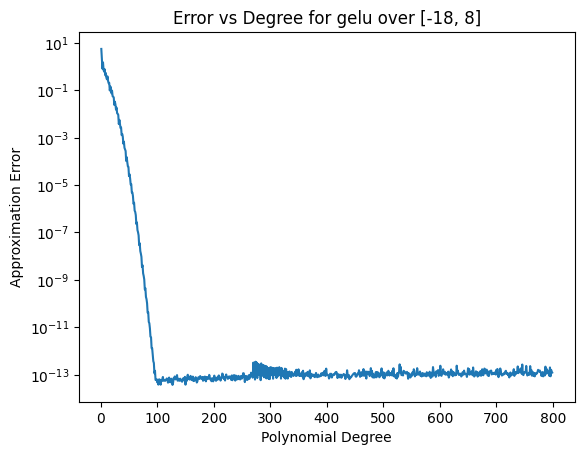

In [83]:
a, b = -18, 8

degrees = []
errors = []
for n in range(1, 800):
    error = compute_error_gelu(n)
    degrees.append(n)
    errors.append(error)

plt.plot(degrees, errors)
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Approximation Error')
plt.title('Error vs Degree for gelu over [{}, {}]'.format(a, b))
plt.show()

# tanh

In [135]:
def func_tanh(x):
    return np.tanh(x)

a, b = -20, 20

def compute_error_tanh(n):
    x_cheb = np.polynomial.chebyshev.chebpts2(n + 1)
    x = denormalize(x_cheb)
    y = func_tanh(x)
    coef = Chebyshev.fit(x_cheb, y, n).coef
    cheb_poly = Chebyshev(coef)
    
    # Compute error
    x_dense = np.linspace(a, b, 1000)
    x_norm = normalize(x_dense)
    y_true = func_tanh(x_dense)
    y_approx = cheb_poly(x_norm)
    error = np.max(np.abs(y_true - y_approx))
    return error

epsilon = 1e-10  # Target approximation error # 1.5143354625823946e-10
n = 1
while True:
    error = compute_error_tanh(n)
    if error < epsilon:
        break
    n += 1

print(f"Degree required for 1/x over [{a}, {b}] with error < {epsilon}: n = {n}")
print(f"Maximum error achieved: {error}")

Degree required for 1/x over [-20, 20] with error < 1e-10: n = 297
Maximum error achieved: 9.426581737415063e-11


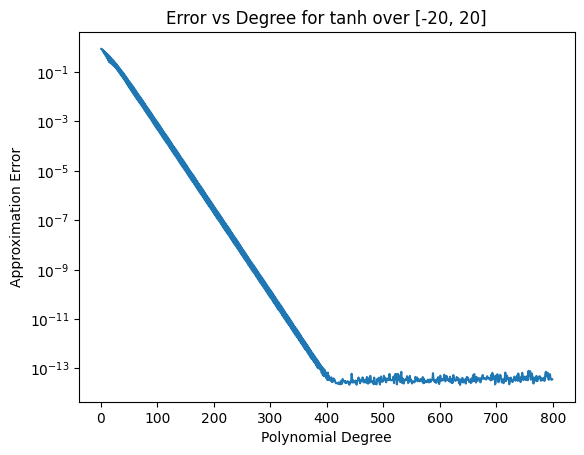

In [85]:
a, b = -20, 20

degrees = []
errors = []
for n in range(1, 800):
    error = compute_error_tanh(n)
    degrees.append(n)
    errors.append(error)

plt.plot(degrees, errors)
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Approximation Error')
plt.title('Error vs Degree for tanh over [{}, {}]'.format(a, b))
plt.show()

In [86]:
import numpy as np
from numpy.polynomial import Chebyshev
import matplotlib.pyplot as plt

def func_inv(x):
    return 1 / x

a, b = 2, 5000

def normalize(x):
    return (2 * x - (b + a)) / (b - a)

def denormalize(x_norm):
    return ((x_norm * (b - a)) + (b + a)) / 2

def compute_error_fixed_degree(n):
    x_cheb = np.polynomial.chebyshev.chebpts2(n + 1)
    x = denormalize(x_cheb)
    y = func_inv(x)
    coef = Chebyshev.fit(x_cheb, y, n).coef
    cheb_poly = Chebyshev(coef)
    
    # Compute maximum error over a dense set of points
    x_dense = np.linspace(a, b, 10000)
    x_norm = normalize(x_dense)
    y_true = func_inv(x_dense)
    y_approx = cheb_poly(x_norm)
    error = np.max(np.abs(y_true - y_approx))
    return error

n = 119  # Degree from the paper
error = compute_error_fixed_degree(n)
print(f"Degree used: n = {n}")
print(f"Maximum error achieved: {error}")


Degree used: n = 119
Maximum error achieved: 0.004273725775988779


In [91]:
import numpy as np
from numpy.polynomial import Chebyshev
import matplotlib.pyplot as plt

def func_inv(x):
    return 1 / x

a, b = 3, 130000

def normalize(x):
    return (2 * x - (b + a)) / (b - a)

def denormalize(x_norm):
    return ((x_norm * (b - a)) + (b + a)) / 2

def compute_error_fixed_degree(n):
    x_cheb = np.polynomial.chebyshev.chebpts2(n + 1)
    x = denormalize(x_cheb)
    y = func_inv(x)
    coef = Chebyshev.fit(x_cheb, y, n).coef
    cheb_poly = Chebyshev(coef)
    
    # Compute maximum error over a dense set of points
    x_dense = np.linspace(a, b, 10000)
    x_norm = normalize(x_dense)
    y_true = func_inv(x_dense)
    y_approx = cheb_poly(x_norm)
    error = np.max(np.abs(y_true - y_approx))
    return error

n = 200  # Degree from the paper
error = compute_error_fixed_degree(n)
print(f"Degree used: n = {n}")
print(f"Maximum error achieved: {error}")


Degree used: n = 200
Maximum error achieved: 0.02946140865810594


In [ ]:
from scipy.special import erf

def func_gelu(x):
    return x * 0.5 * (1 + erf(x / np.sqrt(2)))

a, b = -14, 11  # Adjust as per your data

def compute_error_gelu(n):
    # Normalize interval
    x_cheb = np.polynomial.chebyshev.chebpts2(n + 1)
    x = denormalize(x_cheb)
    y = func_gelu(x)
    coef = Chebyshev.fit(x_cheb, y, n).coef
    cheb_poly = Chebyshev(coef)
    
    # Compute error
    x_dense = np.linspace(a, b, 1000)
    x_norm = normalize(x_dense)
    y_true = func_gelu(x_dense)
    y_approx = cheb_poly(x_norm)
    error = np.max(np.abs(y_true - y_approx))
    return error


In [104]:
from scipy.special import erf
def func_gelu(x):
    return x * 0.5 * (1 + erf(x / np.sqrt(2)))

a, b = -14, 11  # Adjust as per your data

def normalize(x):
    return (2 * x - (b + a)) / (b - a)

def denormalize(x_norm):
    return ((x_norm * (b - a)) + (b + a)) / 2

def compute_error_fixed_degree(n):
    x_cheb = np.polynomial.chebyshev.chebpts2(n + 1)
    x = denormalize(x_cheb)
    y = func_gelu(x)
    coef = Chebyshev.fit(x_cheb, y, n).coef
    cheb_poly = Chebyshev(coef)
    
    # Compute maximum error over a dense set of points
    x_dense = np.linspace(a, b, 10000)
    x_norm = normalize(x_dense)
    y_true = func_gelu(x_dense)
    y_approx = cheb_poly(x_norm)
    error = np.max(np.abs(y_true - y_approx))
    return error

n = 119  # Degree from the paper
error = compute_error_fixed_degree(n)
print(f"Degree used: n = {n}")
print(f"Maximum error achieved: {error}")


Degree used: n = 119
Maximum error achieved: 7.105427357601002e-14


In [119]:
from scipy.special import erf
def func_gelu(x):
    return x * 0.5 * (1 + erf(x / np.sqrt(2)))

a, b = -18, 8  # Adjust as per your data

def normalize(x):
    return (2 * x - (b + a)) / (b - a)

def denormalize(x_norm):
    return ((x_norm * (b - a)) + (b + a)) / 2

def compute_error_fixed_degree(n):
    x_cheb = np.polynomial.chebyshev.chebpts2(n + 1)
    x = denormalize(x_cheb)
    y = func_gelu(x)
    coef = Chebyshev.fit(x_cheb, y, n).coef
    cheb_poly = Chebyshev(coef)
    
    # Compute maximum error over a dense set of points
    x_dense = np.linspace(a, b, 10000)
    x_norm = normalize(x_dense)
    y_true = func_gelu(x_dense)
    y_approx = cheb_poly(x_norm)
    error = np.max(np.abs(y_true - y_approx))
    return error

n = 59  # Degree from the paper
error = compute_error_fixed_degree(n)
print(f"Degree used: n = {n}")
print(f"Maximum error achieved: {error}")


Degree used: n = 59
Maximum error achieved: 1.8033960389185477e-06


In [ ]:
def func_tanh(x):
    return np.tanh(x)

a, b = -20, 20

def compute_error_tanh(n):
    x_cheb = np.polynomial.chebyshev.chebpts2(n + 1)
    x = denormalize(x_cheb)
    y = func_tanh(x)
    coef = Chebyshev.fit(x_cheb, y, n).coef
    cheb_poly = Chebyshev(coef)
    
    # Compute error
    x_dense = np.linspace(a, b, 1000)
    x_norm = normalize(x_dense)
    y_true = func_tanh(x_dense)
    y_approx = cheb_poly(x_norm)
    error = np.max(np.abs(y_true - y_approx))
    return error

epsilon = 1e-10  # Target approximation error
n = 1
while True:
    error = compute_error_tanh(n)
    if error < epsilon:
        break
    n += 1

print(f"Degree required for 1/x over [{a}, {b}] with error < {epsilon}: n = {n}")
print(f"Maximum error achieved: {error}")

In [133]:
def func_tanh(x):
    return np.tanh(x)

a, b = -20, 20  # Adjust as per your data

def normalize(x):
    return (2 * x - (b + a)) / (b - a)

def denormalize(x_norm):
    return ((x_norm * (b - a)) + (b + a)) / 2

def compute_error_fixed_degree(n):
    x_cheb = np.polynomial.chebyshev.chebpts2(n + 1)
    x = denormalize(x_cheb)
    y = func_tanh(x)
    coef = Chebyshev.fit(x_cheb, y, n).coef
    cheb_poly = Chebyshev(coef)
    
    # Compute maximum error over a dense set of points
    x_dense = np.linspace(a, b, 10000)
    x_norm = normalize(x_dense)
    y_true = func_tanh(x_dense)
    y_approx = cheb_poly(x_norm)
    error = np.max(np.abs(y_true - y_approx))
    return error

n = 300  # Degree from the paper
error = compute_error_fixed_degree(n)
print(f"Degree used: n = {n}")
print(f"Maximum error achieved: {error}")

Degree used: n = 300
Maximum error achieved: 1.5143354625823946e-10
